In [1]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score

np.random.seed(7)

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

## Data pre processing

### Access

In [2]:
data = pd.read_csv('dataset.csv').drop('id', axis=1)
data.head(3)
dfi.export(data.head(), 'Images/data_original.jpeg')

[0803/155515.523970:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0803/155515.642555:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0803/155515.857872:INFO:headless_shell.cc(660)] Written to file /tmp/tmpm8bu1fzz/temp.png.


### Target balancement 

In [3]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [4]:
n = data.query('stroke == 1').shape[0]

i = data.query('stroke == 0').index
i_sampled = np.random.choice(i, n+2)

data = pd.concat([data.query('stroke == 1'), data.loc[i_sampled]], axis=0).sort_index()
display(data['stroke'].value_counts())

0    251
1    249
Name: stroke, dtype: int64

### Format correction

In [5]:
#variavel 'id' foi desconsiderada
qualitatives = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                'work_type', 'Residence_type', 'smoking_status', 'stroke']

quantitatives = ['age', 'avg_glucose_level', 'bmi']

In [6]:
data[qualitatives].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 5108
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          500 non-null    object
 1   hypertension    500 non-null    int64 
 2   heart_disease   500 non-null    int64 
 3   ever_married    500 non-null    object
 4   work_type       500 non-null    object
 5   Residence_type  500 non-null    object
 6   smoking_status  500 non-null    object
 7   stroke          500 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 35.2+ KB


In [7]:
data[quantitatives].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 5108
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                500 non-null    float64
 1   avg_glucose_level  500 non-null    float64
 2   bmi                454 non-null    float64
dtypes: float64(3)
memory usage: 15.6 KB


In [8]:
#Substituição de Male por 1 e rename
data['gender'] = data['gender'].apply(lambda x:1 if x == 'Male' else 0)
data.rename({'gender':'Male'}, axis=1, inplace=True)

In [9]:
#Substituição de Yes por 1
data['ever_married'] = data['ever_married'].apply(lambda x:1 if x == 'Yes' else 0)

In [10]:
#Substituição de Urban por 1 e rename
data['Residence_type'] = data['Residence_type'].apply(lambda x:1 if x == 'Urban' else 0)
data.rename({'Residence_type':'Residence_type_urban'}, axis=1, inplace=True)

In [11]:
#Extração de novas colunas apartir dos diferentes possíveis valores. Exclusão de children
data = pd.concat([data.drop('work_type', axis=1), 
                  pd.get_dummies(data['work_type']).drop('children', axis=1)], axis=1)
data.rename({'Private':'Private_job'}, axis=1,inplace=True)

In [12]:
#Extração de novas colunas apartir dos diferentes possíveis valores. Exclusão de Unknown
data = pd.concat([data.drop('smoking_status', axis=1), 
                  pd.get_dummies(data['smoking_status']).drop('Unknown', axis=1)], axis=1)

### Missing values correction

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 5108
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Male                  500 non-null    int64  
 1   age                   500 non-null    float64
 2   hypertension          500 non-null    int64  
 3   heart_disease         500 non-null    int64  
 4   ever_married          500 non-null    int64  
 5   Residence_type_urban  500 non-null    int64  
 6   avg_glucose_level     500 non-null    float64
 7   bmi                   454 non-null    float64
 8   stroke                500 non-null    int64  
 9   Govt_job              500 non-null    uint8  
 10  Private_job           500 non-null    uint8  
 11  Self-employed         500 non-null    uint8  
 12  formerly smoked       500 non-null    uint8  
 13  never smoked          500 non-null    uint8  
 14  smokes                500 non-null    uint8  
dtypes: float64(3), int64(6

In [14]:
stroke = data.query('stroke == 1')
not_stroke = data.query('stroke == 0')

In [15]:
stroke['bmi'].isnull().value_counts(normalize=False).to_frame()

,bmi
False,209
True,40


In [16]:
not_stroke['bmi'].isnull().value_counts(normalize=False).to_frame()

,bmi
False,245
True,6


In [17]:
median = stroke['bmi'].median()
stroke['bmi'].fillna(median, inplace=True)

median = not_stroke['bmi'].median()
not_stroke['bmi'].fillna(median, inplace=True)

data = pd.concat([stroke, not_stroke], axis=0).sort_index()

/tmp/ipykernel_7918/2437693244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke['bmi'].fillna(median, inplace=True)
/tmp/ipykernel_7918/2437693244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_stroke['bmi'].fillna(median, inplace=True)


### Outliers detection and treatment

In [18]:
sns.set_style('whitegrid')

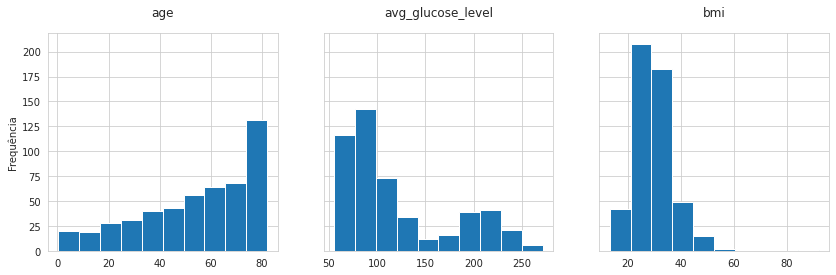

In [19]:
i = 0
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(14,4))

for column in quantitatives:
    ax[i].set_title(column, y=1.05)
    data[column].plot(kind='hist', ax=ax[i])
    ax[i].set_ylabel('Frequência')
    i += 1
    
plt.savefig('Images/hist_com_anomalias.jpeg', bbox_inches="tight")

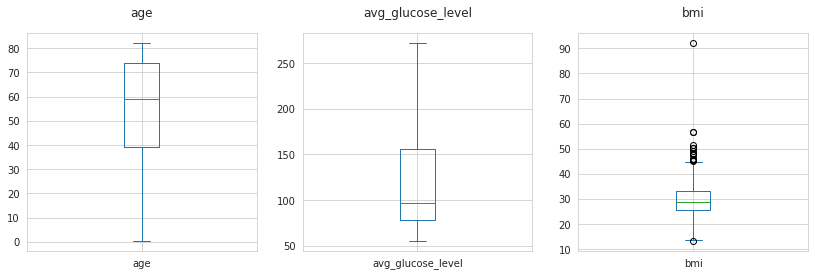

In [20]:
i = 0
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(14,4))

for column in quantitatives:
    ax[i].set_title(column, y=1.05)
    data[column].plot(kind='box', ax=ax[i])
    i += 1
    
plt.savefig('Images/box_com_anomalias.jpeg', bbox_inches="tight")

In [21]:
q1 = data['bmi'].quantile(0.25)
q3 = data['bmi'].quantile(0.75)

IQR = q3 - q1

limite_superior = data['bmi'].median() + 1.5*IQR
limite_inferior = data['bmi'].median() - 1.5*IQR

data['bmi'] = data['bmi'].apply(lambda x:limite_superior if x > limite_superior else x)
data['bmi'] = data['bmi'].apply(lambda x:limite_inferior if x < limite_inferior else x)

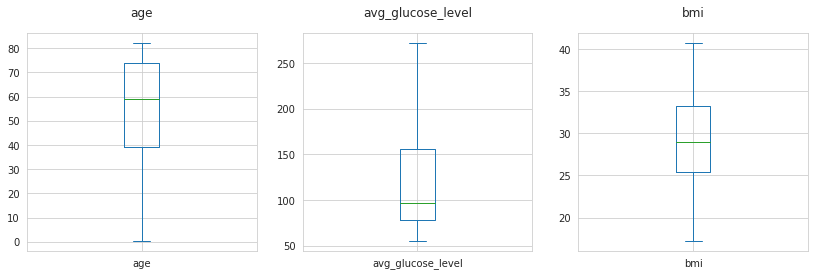

In [22]:
i = 0
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(14,4))

for column in quantitatives:
    ax[i].set_title(column, y=1.05)
    data[column].plot(kind='box', ax=ax[i])
    i += 1
    
plt.savefig('Images/hist_sem_anomalias.jpeg', bbox_inches="tight")

### Normal curve verifying

In [23]:
for column in quantitatives:
    print('\n', column, shapiro(data[column]))


 age ShapiroResult(statistic=0.9184489250183105, pvalue=8.537557418775393e-16)

 avg_glucose_level ShapiroResult(statistic=0.8474879860877991, pvalue=1.4570601707343144e-21)

 bmi ShapiroResult(statistic=0.972310483455658, pvalue=4.061904590457743e-08)


Não se pode assumir normalidade nas variáveis quantitativas.

In [24]:
dfi.export(data.head(), 'Images/data_mod.jpeg')

[0803/155522.399822:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0803/155522.627381:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0803/155522.840886:INFO:headless_shell.cc(660)] Written to file /tmp/tmpvpoqv7uj/temp.png.
[0803/155523.007358:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0803/155523.259825:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0803/155523.488085:INFO:headless_shell.cc(660)] Written to file /tmp/tmpwtyexk5a/temp.png.


## Processing

### scaling data

In [25]:
min_max_scaler = MinMaxScaler()
data[quantitatives] = min_max_scaler.fit_transform(data[quantitatives]) 

### Splitting

In [26]:
X = data.drop('stroke', axis=1)
y = data['stroke']

### Modeling

#### SVC

In [27]:
kf = KFold(shuffle=True, random_state=7)

falsos_positivos = []
falsos_negativos = []
verdadeiros_positivos = []
verdadeiros_negativos = []
rocs = []

for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    svc_model = SVC(random_state=7, probability=True)
    svc_model.fit(X_train, y_train)
    
    rocs.append(roc_auc_score(y_true=y_test, y_score=svc_model.predict_proba(X_test)[:, 1]))
    
    cm = confusion_matrix(y_test, svc_model.predict(X_test))
    
    total = cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
    
    falso_positivo = cm[0][1] / total
    falsos_positivos.append(falso_positivo)
    
    falso_negativo = cm[1][0] / total
    falsos_negativos.append(falso_negativo)
    
    verdadeiro_positivo = cm[1][1] / total
    verdadeiros_positivos.append(verdadeiro_positivo)
    
    verdadeiro_negativo = cm[0][0] / total
    verdadeiros_negativos.append(verdadeiro_negativo)
    
falsos_positivos = np.array(falsos_positivos)
falsos_negativos = np.array(falsos_negativos)
verdadeiros_positivos = np.array(verdadeiros_positivos)
verdadeiros_negativos = np.array(verdadeiros_negativos)
rocs = np.array(rocs)

print('Taxa de acertos: %.2f%% +- %.2f%%' % (verdadeiros_positivos.mean()*100 + verdadeiros_negativos.mean()*100, 
                                             verdadeiros_positivos.std()*100 + verdadeiros_negativos.std()*100))

print('Taxa de falsos positivos: %.2f%% +- %.2f%%' % (falsos_positivos.mean()*100, falsos_positivos.std()*100))
print('Taxa de falsos negativos: %.2f%% +- %.2f%%' % (falsos_negativos.mean()*100, falsos_negativos.std()*100))

print('ROC Score: %.2f +- %.2f' % (rocs.mean(), rocs.std()))

Taxa de acertos: 77.00% +- 5.32%
Taxa de falsos positivos: 15.40% +- 2.15%
Taxa de falsos negativos: 7.60% +- 3.20%
ROC Score: 0.83 +- 0.02


#### Random Forest Classifer

In [28]:
kf = KFold(shuffle=True, random_state=7)

falsos_positivos = []
falsos_negativos = []
verdadeiros_positivos = []
verdadeiros_negativos = []
rocs = []

for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    forest_model = RandomForestClassifier(random_state=7)
    forest_model.fit(X_train, y_train)
    
    rocs.append(roc_auc_score(y_true=y_test, y_score=forest_model.predict_proba(X_test)[:, 1]))
    
    cm = confusion_matrix(y_test, forest_model.predict(X_test))
    
    total = cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
    
    falso_positivo = cm[0][1] / total
    falsos_positivos.append(falso_positivo)
    
    falso_negativo = cm[1][0] / total
    falsos_negativos.append(falso_negativo)
    
    verdadeiro_positivo = cm[1][1] / total
    verdadeiros_positivos.append(verdadeiro_positivo)
    
    verdadeiro_negativo = cm[0][0] / total
    verdadeiros_negativos.append(verdadeiro_negativo)
    
falsos_positivos = np.array(falsos_positivos)
falsos_negativos = np.array(falsos_negativos)
verdadeiros_positivos = np.array(verdadeiros_positivos)
verdadeiros_negativos = np.array(verdadeiros_negativos)
rocs = np.array(rocs)

print('Taxa de acertos: %.2f%% +- %.2f%%' % (verdadeiros_positivos.mean()*100 + verdadeiros_negativos.mean()*100, 
                                             verdadeiros_positivos.std()*100 + verdadeiros_negativos.std()*100))

print('Taxa de falsos positivos: %.2f%% +- %.2f%%' % (falsos_positivos.mean()*100, falsos_positivos.std()*100))
print('Taxa de falsos negativos: %.2f%% +- %.2f%%' % (falsos_negativos.mean()*100, falsos_negativos.std()*100))

print('ROC Score: %.2f +- %.2f' % (rocs.mean(), rocs.std()))

Taxa de acertos: 79.00% +- 6.89%
Taxa de falsos positivos: 13.00% +- 3.22%
Taxa de falsos negativos: 8.00% +- 1.79%
ROC Score: 0.85 +- 0.03


In [29]:
# Taxa de acertos: 77.00% +- 5.32%
# Taxa de falsos positivos: 15.40% +- 2.15%
# Taxa de falsos negativos: 7.60% +- 3.20%
# ROC Score: 0.83 +- 0.02
    
# Taxa de acertos: 79.00% +- 7.00%
# Taxa de falsos positivos: 12.80% +- 3.25%
# Taxa de falsos negativos: 8.20% +- 1.94%
# ROC Score: 0.85 +- 0.03

### Saving models and scaler

In [30]:
file = open('Models/scaler.pk', 'wb')
pk.dump(min_max_scaler, file)
file.close()

file = open('Models/random_forest_classifier.pk', 'wb')
pk.dump(forest_model, file)
file.close()

file = open('Models/svc_classifier.pk', 'wb')
pk.dump(svc_model, file)
file.close()